## '나비야' 악보를 학습데이터로 사용하여 모델 만들기
- 4개의 음표를 입력으로 다음 출력 음표를 예측
- c(도), d(레), ... , b(시)
- 4(4분음표), 8(8분음표)
<img src='img/3_12.png' width='400'>

- 예측 : 두 가지 방법으로  
    ○ 한 스텝 예측 : 4개 입력 & 1개 출력 반복  
    ○ 곡 전체 예측 : 출력이 계속 입력으로 들어감 => 곡 전체 예측 (틀린 부분이 생기면 그 때부터 예측 오류가 계속 누적됨)

In [3]:
import numpy as np

In [5]:
# 코드를 숫자로 만들기

code2idx = { 'c4' :0, 'd4' :1, 'e4' :2, 'f4' :3, 'g4' :4, 'a4' :5, 'b4' :6,
            'c8' :7, 'd8' :8, 'e8' :9, 'f8' :10, 'g8' :11, 'a8' :12, 'b8' :13}

idx2code = { 0 : 'c4', 1 : 'd4', 2 : 'e4' , 3 :'f4 ' , 4 : 'g4', 5 : 'a4',
            6 : 'b4', 7 : 'c8', 8 : 'd8', 9 : 'e8', 10 : 'f8', 11 : 'g8', 
            12 : 'a8', 13 : 'b8' }

len(code2idx)

14

In [6]:
# 순차적인 음표를 지정한 윈도우 크기만큼 잘라 데이터셋 생성하는 함수

def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq) - window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset]) 
                # subset(음표 리스트)를 숫자로 만들어 리스트로 만든 뒤, append
    return np.array(dataset)

In [7]:
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

dataset = seq2dataset(seq, window_size=4)

print(dataset.shape)
print(dataset)

(50, 5)
[[11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  8]
 [ 8  1  7  8  9]
 [ 1  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 11]
 [ 9 10 11 11  4]
 [10 11 11  4 11]
 [11 11  4 11  9]
 [11  4 11  9  9]
 [ 4 11  9  9  9]
 [11  9  9  9 10]
 [ 9  9  9 10  8]
 [ 9  9 10  8  1]
 [ 9 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]
 [11  9  9  2  8]
 [ 9  9  2  8  8]
 [ 9  2  8  8  8]
 [ 2  8  8  8  8]
 [ 8  8  8  8  8]
 [ 8  8  8  8  9]
 [ 8  8  8  9  3]
 [ 8  8  9  3  9]
 [ 8  9  3  9  9]
 [ 9  3  9  9  9]
 [ 3  9  9  9  9]
 [ 9  9  9  9  9]
 [ 9  9  9  9 10]
 [ 9  9  9 10  4]
 [ 9  9 10  4 11]
 [ 9 10  4 11  9]
 [10  4 11  9  2]
 [ 4 11  9  2 10]
 [11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]]


### 1. 다층 퍼셉트론 신경망 모델

In [16]:
# 만드려는 모델

# model = Sequential()
# model.add(Dense(128, input_dim=4, activation='relu'))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(one_hot_vec_size, activation='softmax'))

In [18]:
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.python.keras.utils import np_utils

In [19]:
np.random.seed(5)

In [20]:
# 손실 이력 클래스 정의

class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [35]:
# 입력(X)와 출력(Y) 변수로 분리하기 (데이터 생성코드는 위에 있음)

x_train = dataset[:, 0:4]
y_train = dataset[:, 4]

max_idx_value = 13

In [22]:
# 입력값 정규화 시키기

x_train = x_train / float(max_idx_value)

In [36]:
# 라벨값에 대한 one-hot 인코딩 수행

y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]
one_hot_vec_size

12

In [40]:
# 모델 구성하기

model = Sequential()
model.add(Dense(128, input_dim=4, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(one_hot_vec_size, activation='softmax'))

In [41]:
# 모델 학습과정 설정하기

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = LossHistory()  # 손실 이력 객체 생성
history.init()

In [42]:
# 모델 학습시키기

model.fit(x_train, y_train, epochs=2000, batch_size=10, verbose=2, callbacks=[history])

Epoch 1/2000
5/5 - 0s - loss: 2.6433 - accuracy: 0.1400
Epoch 2/2000
5/5 - 0s - loss: 2.0443 - accuracy: 0.3400
Epoch 3/2000
5/5 - 0s - loss: 1.7816 - accuracy: 0.3600
Epoch 4/2000
5/5 - 0s - loss: 1.7363 - accuracy: 0.3800
Epoch 5/2000
5/5 - 0s - loss: 1.6511 - accuracy: 0.4000
Epoch 6/2000
5/5 - 0s - loss: 1.6245 - accuracy: 0.3800
Epoch 7/2000
5/5 - 0s - loss: 1.5752 - accuracy: 0.4000
Epoch 8/2000
5/5 - 0s - loss: 1.5279 - accuracy: 0.4800
Epoch 9/2000
5/5 - 0s - loss: 1.4867 - accuracy: 0.5000
Epoch 10/2000
5/5 - 0s - loss: 1.4847 - accuracy: 0.5000
Epoch 11/2000
5/5 - 0s - loss: 1.4381 - accuracy: 0.5400
Epoch 12/2000
5/5 - 0s - loss: 1.4146 - accuracy: 0.5200
Epoch 13/2000
5/5 - 0s - loss: 1.4129 - accuracy: 0.5200
Epoch 14/2000
5/5 - 0s - loss: 1.3904 - accuracy: 0.5200
Epoch 15/2000
5/5 - 0s - loss: 1.3880 - accuracy: 0.5400
Epoch 16/2000
5/5 - 0s - loss: 1.3491 - accuracy: 0.5600
Epoch 17/2000
5/5 - 0s - loss: 1.3469 - accuracy: 0.5600
Epoch 18/2000
5/5 - 0s - loss: 1.3564 - 

Epoch 145/2000
5/5 - 0s - loss: 0.5620 - accuracy: 0.8200
Epoch 146/2000
5/5 - 0s - loss: 0.5534 - accuracy: 0.8200
Epoch 147/2000
5/5 - 0s - loss: 0.5473 - accuracy: 0.8000
Epoch 148/2000
5/5 - 0s - loss: 0.5569 - accuracy: 0.8400
Epoch 149/2000
5/5 - 0s - loss: 0.5721 - accuracy: 0.8000
Epoch 150/2000
5/5 - 0s - loss: 0.5435 - accuracy: 0.7800
Epoch 151/2000
5/5 - 0s - loss: 0.5383 - accuracy: 0.7600
Epoch 152/2000
5/5 - 0s - loss: 0.5454 - accuracy: 0.8200
Epoch 153/2000
5/5 - 0s - loss: 0.5381 - accuracy: 0.8200
Epoch 154/2000
5/5 - 0s - loss: 0.5646 - accuracy: 0.7600
Epoch 155/2000
5/5 - 0s - loss: 0.5505 - accuracy: 0.7800
Epoch 156/2000
5/5 - 0s - loss: 0.5261 - accuracy: 0.8000
Epoch 157/2000
5/5 - 0s - loss: 0.5374 - accuracy: 0.8400
Epoch 158/2000
5/5 - 0s - loss: 0.5576 - accuracy: 0.7600
Epoch 159/2000
5/5 - 0s - loss: 0.5365 - accuracy: 0.7800
Epoch 160/2000
5/5 - 0s - loss: 0.5290 - accuracy: 0.8000
Epoch 161/2000
5/5 - 0s - loss: 0.5298 - accuracy: 0.8200
Epoch 162/2000

Epoch 287/2000
5/5 - 0s - loss: 0.3607 - accuracy: 0.8200
Epoch 288/2000
5/5 - 0s - loss: 0.3322 - accuracy: 0.8800
Epoch 289/2000
5/5 - 0s - loss: 0.3287 - accuracy: 0.8400
Epoch 290/2000
5/5 - 0s - loss: 0.3202 - accuracy: 0.8800
Epoch 291/2000
5/5 - 0s - loss: 0.3234 - accuracy: 0.8800
Epoch 292/2000
5/5 - 0s - loss: 0.3393 - accuracy: 0.9000
Epoch 293/2000
5/5 - 0s - loss: 0.3496 - accuracy: 0.8200
Epoch 294/2000
5/5 - 0s - loss: 0.3356 - accuracy: 0.8800
Epoch 295/2000
5/5 - 0s - loss: 0.3186 - accuracy: 0.9000
Epoch 296/2000
5/5 - 0s - loss: 0.3204 - accuracy: 0.9200
Epoch 297/2000
5/5 - 0s - loss: 0.3192 - accuracy: 0.8600
Epoch 298/2000
5/5 - 0s - loss: 0.3310 - accuracy: 0.8800
Epoch 299/2000
5/5 - 0s - loss: 0.3408 - accuracy: 0.8600
Epoch 300/2000
5/5 - 0s - loss: 0.3273 - accuracy: 0.9000
Epoch 301/2000
5/5 - 0s - loss: 0.3284 - accuracy: 0.8600
Epoch 302/2000
5/5 - 0s - loss: 0.3366 - accuracy: 0.8600
Epoch 303/2000
5/5 - 0s - loss: 0.3063 - accuracy: 0.9000
Epoch 304/2000

Epoch 429/2000
5/5 - 0s - loss: 0.2503 - accuracy: 0.8600
Epoch 430/2000
5/5 - 0s - loss: 0.2590 - accuracy: 0.8800
Epoch 431/2000
5/5 - 0s - loss: 0.2511 - accuracy: 0.9000
Epoch 432/2000
5/5 - 0s - loss: 0.2744 - accuracy: 0.8600
Epoch 433/2000
5/5 - 0s - loss: 0.2562 - accuracy: 0.8800
Epoch 434/2000
5/5 - 0s - loss: 0.2524 - accuracy: 0.9000
Epoch 435/2000
5/5 - 0s - loss: 0.2595 - accuracy: 0.9000
Epoch 436/2000
5/5 - 0s - loss: 0.2495 - accuracy: 0.9000
Epoch 437/2000
5/5 - 0s - loss: 0.2516 - accuracy: 0.9200
Epoch 438/2000
5/5 - 0s - loss: 0.2677 - accuracy: 0.8600
Epoch 439/2000
5/5 - 0s - loss: 0.2545 - accuracy: 0.8800
Epoch 440/2000
5/5 - 0s - loss: 0.2549 - accuracy: 0.9000
Epoch 441/2000
5/5 - 0s - loss: 0.2543 - accuracy: 0.9000
Epoch 442/2000
5/5 - 0s - loss: 0.2780 - accuracy: 0.8400
Epoch 443/2000
5/5 - 0s - loss: 0.2583 - accuracy: 0.9000
Epoch 444/2000
5/5 - 0s - loss: 0.2722 - accuracy: 0.9000
Epoch 445/2000
5/5 - 0s - loss: 0.2542 - accuracy: 0.9200
Epoch 446/2000

Epoch 571/2000
5/5 - 0s - loss: 0.2103 - accuracy: 0.9000
Epoch 572/2000
5/5 - 0s - loss: 0.2129 - accuracy: 0.9200
Epoch 573/2000
5/5 - 0s - loss: 0.2346 - accuracy: 0.9200
Epoch 574/2000
5/5 - 0s - loss: 0.1997 - accuracy: 0.9200
Epoch 575/2000
5/5 - 0s - loss: 0.2216 - accuracy: 0.8800
Epoch 576/2000
5/5 - 0s - loss: 0.2316 - accuracy: 0.9000
Epoch 577/2000
5/5 - 0s - loss: 0.2234 - accuracy: 0.9000
Epoch 578/2000
5/5 - 0s - loss: 0.2208 - accuracy: 0.8600
Epoch 579/2000
5/5 - 0s - loss: 0.2522 - accuracy: 0.8800
Epoch 580/2000
5/5 - 0s - loss: 0.2271 - accuracy: 0.9000
Epoch 581/2000
5/5 - 0s - loss: 0.2157 - accuracy: 0.9000
Epoch 582/2000
5/5 - 0s - loss: 0.2398 - accuracy: 0.9000
Epoch 583/2000
5/5 - 0s - loss: 0.2201 - accuracy: 0.9000
Epoch 584/2000
5/5 - 0s - loss: 0.2251 - accuracy: 0.9000
Epoch 585/2000
5/5 - 0s - loss: 0.2118 - accuracy: 0.8800
Epoch 586/2000
5/5 - 0s - loss: 0.2204 - accuracy: 0.9000
Epoch 587/2000
5/5 - 0s - loss: 0.2207 - accuracy: 0.9000
Epoch 588/2000

Epoch 713/2000
5/5 - 0s - loss: 0.2322 - accuracy: 0.9000
Epoch 714/2000
5/5 - 0s - loss: 0.2140 - accuracy: 0.9000
Epoch 715/2000
5/5 - 0s - loss: 0.2244 - accuracy: 0.8800
Epoch 716/2000
5/5 - 0s - loss: 0.2330 - accuracy: 0.8800
Epoch 717/2000
5/5 - 0s - loss: 0.2220 - accuracy: 0.9200
Epoch 718/2000
5/5 - 0s - loss: 0.2133 - accuracy: 0.9000
Epoch 719/2000
5/5 - 0s - loss: 0.2019 - accuracy: 0.9400
Epoch 720/2000
5/5 - 0s - loss: 0.2031 - accuracy: 0.9000
Epoch 721/2000
5/5 - 0s - loss: 0.2008 - accuracy: 0.9000
Epoch 722/2000
5/5 - 0s - loss: 0.2020 - accuracy: 0.9200
Epoch 723/2000
5/5 - 0s - loss: 0.2089 - accuracy: 0.8800
Epoch 724/2000
5/5 - 0s - loss: 0.2010 - accuracy: 0.9000
Epoch 725/2000
5/5 - 0s - loss: 0.2146 - accuracy: 0.8800
Epoch 726/2000
5/5 - 0s - loss: 0.2294 - accuracy: 0.8400
Epoch 727/2000
5/5 - 0s - loss: 0.1940 - accuracy: 0.9000
Epoch 728/2000
5/5 - 0s - loss: 0.2298 - accuracy: 0.9000
Epoch 729/2000
5/5 - 0s - loss: 0.2058 - accuracy: 0.9200
Epoch 730/2000

Epoch 855/2000
5/5 - 0s - loss: 0.2027 - accuracy: 0.9200
Epoch 856/2000
5/5 - 0s - loss: 0.1941 - accuracy: 0.9200
Epoch 857/2000
5/5 - 0s - loss: 0.1956 - accuracy: 0.8600
Epoch 858/2000
5/5 - 0s - loss: 0.1945 - accuracy: 0.9200
Epoch 859/2000
5/5 - 0s - loss: 0.1951 - accuracy: 0.9000
Epoch 860/2000
5/5 - 0s - loss: 0.1963 - accuracy: 0.8800
Epoch 861/2000
5/5 - 0s - loss: 0.2030 - accuracy: 0.9200
Epoch 862/2000
5/5 - 0s - loss: 0.2029 - accuracy: 0.9200
Epoch 863/2000
5/5 - 0s - loss: 0.2150 - accuracy: 0.8600
Epoch 864/2000
5/5 - 0s - loss: 0.1997 - accuracy: 0.9000
Epoch 865/2000
5/5 - 0s - loss: 0.1934 - accuracy: 0.9200
Epoch 866/2000
5/5 - 0s - loss: 0.1943 - accuracy: 0.9200
Epoch 867/2000
5/5 - 0s - loss: 0.1882 - accuracy: 0.9000
Epoch 868/2000
5/5 - 0s - loss: 0.1930 - accuracy: 0.9000
Epoch 869/2000
5/5 - 0s - loss: 0.1943 - accuracy: 0.9000
Epoch 870/2000
5/5 - 0s - loss: 0.2027 - accuracy: 0.9200
Epoch 871/2000
5/5 - 0s - loss: 0.2176 - accuracy: 0.8600
Epoch 872/2000

Epoch 997/2000
5/5 - 0s - loss: 0.1846 - accuracy: 0.9200
Epoch 998/2000
5/5 - 0s - loss: 0.1870 - accuracy: 0.9200
Epoch 999/2000
5/5 - 0s - loss: 0.1862 - accuracy: 0.8800
Epoch 1000/2000
5/5 - 0s - loss: 0.2020 - accuracy: 0.8800
Epoch 1001/2000
5/5 - 0s - loss: 0.1895 - accuracy: 0.9000
Epoch 1002/2000
5/5 - 0s - loss: 0.2026 - accuracy: 0.8600
Epoch 1003/2000
5/5 - 0s - loss: 0.1770 - accuracy: 0.9200
Epoch 1004/2000
5/5 - 0s - loss: 0.1851 - accuracy: 0.9000
Epoch 1005/2000
5/5 - 0s - loss: 0.1885 - accuracy: 0.9200
Epoch 1006/2000
5/5 - 0s - loss: 0.1771 - accuracy: 0.9200
Epoch 1007/2000
5/5 - 0s - loss: 0.1865 - accuracy: 0.8800
Epoch 1008/2000
5/5 - 0s - loss: 0.1778 - accuracy: 0.9200
Epoch 1009/2000
5/5 - 0s - loss: 0.1730 - accuracy: 0.9000
Epoch 1010/2000
5/5 - 0s - loss: 0.1854 - accuracy: 0.9200
Epoch 1011/2000
5/5 - 0s - loss: 0.1879 - accuracy: 0.9200
Epoch 1012/2000
5/5 - 0s - loss: 0.1877 - accuracy: 0.9200
Epoch 1013/2000
5/5 - 0s - loss: 0.1871 - accuracy: 0.9000


Epoch 1136/2000
5/5 - 0s - loss: 0.1747 - accuracy: 0.9000
Epoch 1137/2000
5/5 - 0s - loss: 0.1917 - accuracy: 0.8800
Epoch 1138/2000
5/5 - 0s - loss: 0.1794 - accuracy: 0.9200
Epoch 1139/2000
5/5 - 0s - loss: 0.1733 - accuracy: 0.9200
Epoch 1140/2000
5/5 - 0s - loss: 0.1852 - accuracy: 0.9000
Epoch 1141/2000
5/5 - 0s - loss: 0.1789 - accuracy: 0.9200
Epoch 1142/2000
5/5 - 0s - loss: 0.2016 - accuracy: 0.8800
Epoch 1143/2000
5/5 - 0s - loss: 0.2018 - accuracy: 0.8600
Epoch 1144/2000
5/5 - 0s - loss: 0.1857 - accuracy: 0.8800
Epoch 1145/2000
5/5 - 0s - loss: 0.1856 - accuracy: 0.9200
Epoch 1146/2000
5/5 - 0s - loss: 0.1778 - accuracy: 0.9000
Epoch 1147/2000
5/5 - 0s - loss: 0.1880 - accuracy: 0.8800
Epoch 1148/2000
5/5 - 0s - loss: 0.1965 - accuracy: 0.8800
Epoch 1149/2000
5/5 - 0s - loss: 0.1924 - accuracy: 0.9000
Epoch 1150/2000
5/5 - 0s - loss: 0.1788 - accuracy: 0.8800
Epoch 1151/2000
5/5 - 0s - loss: 0.1791 - accuracy: 0.9000
Epoch 1152/2000
5/5 - 0s - loss: 0.2185 - accuracy: 0.86

Epoch 1275/2000
5/5 - 0s - loss: 0.1647 - accuracy: 0.9200
Epoch 1276/2000
5/5 - 0s - loss: 0.1743 - accuracy: 0.9200
Epoch 1277/2000
5/5 - 0s - loss: 0.1612 - accuracy: 0.9200
Epoch 1278/2000
5/5 - 0s - loss: 0.1704 - accuracy: 0.9200
Epoch 1279/2000
5/5 - 0s - loss: 0.1670 - accuracy: 0.9000
Epoch 1280/2000
5/5 - 0s - loss: 0.1676 - accuracy: 0.9000
Epoch 1281/2000
5/5 - 0s - loss: 0.1702 - accuracy: 0.9200
Epoch 1282/2000
5/5 - 0s - loss: 0.1715 - accuracy: 0.9200
Epoch 1283/2000
5/5 - 0s - loss: 0.1732 - accuracy: 0.9200
Epoch 1284/2000
5/5 - 0s - loss: 0.1671 - accuracy: 0.9200
Epoch 1285/2000
5/5 - 0s - loss: 0.1615 - accuracy: 0.9000
Epoch 1286/2000
5/5 - 0s - loss: 0.1834 - accuracy: 0.8800
Epoch 1287/2000
5/5 - 0s - loss: 0.1737 - accuracy: 0.9000
Epoch 1288/2000
5/5 - 0s - loss: 0.1685 - accuracy: 0.9200
Epoch 1289/2000
5/5 - 0s - loss: 0.1929 - accuracy: 0.8800
Epoch 1290/2000
5/5 - 0s - loss: 0.1708 - accuracy: 0.9400
Epoch 1291/2000
5/5 - 0s - loss: 0.1679 - accuracy: 0.90

Epoch 1414/2000
5/5 - 0s - loss: 0.1637 - accuracy: 0.9200
Epoch 1415/2000
5/5 - 0s - loss: 0.1705 - accuracy: 0.9000
Epoch 1416/2000
5/5 - 0s - loss: 0.1858 - accuracy: 0.8600
Epoch 1417/2000
5/5 - 0s - loss: 0.1618 - accuracy: 0.9400
Epoch 1418/2000
5/5 - 0s - loss: 0.2100 - accuracy: 0.8800
Epoch 1419/2000
5/5 - 0s - loss: 0.1702 - accuracy: 0.9200
Epoch 1420/2000
5/5 - 0s - loss: 0.1753 - accuracy: 0.9000
Epoch 1421/2000
5/5 - 0s - loss: 0.1558 - accuracy: 0.9200
Epoch 1422/2000
5/5 - 0s - loss: 0.1693 - accuracy: 0.9200
Epoch 1423/2000
5/5 - 0s - loss: 0.1573 - accuracy: 0.9200
Epoch 1424/2000
5/5 - 0s - loss: 0.1770 - accuracy: 0.9000
Epoch 1425/2000
5/5 - 0s - loss: 0.1615 - accuracy: 0.9000
Epoch 1426/2000
5/5 - 0s - loss: 0.1848 - accuracy: 0.8800
Epoch 1427/2000
5/5 - 0s - loss: 0.1545 - accuracy: 0.9200
Epoch 1428/2000
5/5 - 0s - loss: 0.2431 - accuracy: 0.9000
Epoch 1429/2000
5/5 - 0s - loss: 0.2009 - accuracy: 0.8600
Epoch 1430/2000
5/5 - 0s - loss: 0.1684 - accuracy: 0.92

Epoch 1553/2000
5/5 - 0s - loss: 0.1538 - accuracy: 0.9200
Epoch 1554/2000
5/5 - 0s - loss: 0.1608 - accuracy: 0.9200
Epoch 1555/2000
5/5 - 0s - loss: 0.1598 - accuracy: 0.9200
Epoch 1556/2000
5/5 - 0s - loss: 0.1642 - accuracy: 0.9200
Epoch 1557/2000
5/5 - 0s - loss: 0.1532 - accuracy: 0.9200
Epoch 1558/2000
5/5 - 0s - loss: 0.1529 - accuracy: 0.9200
Epoch 1559/2000
5/5 - 0s - loss: 0.1732 - accuracy: 0.9200
Epoch 1560/2000
5/5 - 0s - loss: 0.1617 - accuracy: 0.9200
Epoch 1561/2000
5/5 - 0s - loss: 0.1586 - accuracy: 0.9200
Epoch 1562/2000
5/5 - 0s - loss: 0.1579 - accuracy: 0.9200
Epoch 1563/2000
5/5 - 0s - loss: 0.1594 - accuracy: 0.9000
Epoch 1564/2000
5/5 - 0s - loss: 0.1740 - accuracy: 0.8800
Epoch 1565/2000
5/5 - 0s - loss: 0.1689 - accuracy: 0.9000
Epoch 1566/2000
5/5 - 0s - loss: 0.1730 - accuracy: 0.9000
Epoch 1567/2000
5/5 - 0s - loss: 0.1699 - accuracy: 0.9000
Epoch 1568/2000
5/5 - 0s - loss: 0.1583 - accuracy: 0.9000
Epoch 1569/2000
5/5 - 0s - loss: 0.1536 - accuracy: 0.92

Epoch 1692/2000
5/5 - 0s - loss: 0.1553 - accuracy: 0.9000
Epoch 1693/2000
5/5 - 0s - loss: 0.1609 - accuracy: 0.8800
Epoch 1694/2000
5/5 - 0s - loss: 0.1562 - accuracy: 0.9000
Epoch 1695/2000
5/5 - 0s - loss: 0.1615 - accuracy: 0.9200
Epoch 1696/2000
5/5 - 0s - loss: 0.1737 - accuracy: 0.9000
Epoch 1697/2000
5/5 - 0s - loss: 0.1768 - accuracy: 0.9200
Epoch 1698/2000
5/5 - 0s - loss: 0.1829 - accuracy: 0.8800
Epoch 1699/2000
5/5 - 0s - loss: 0.1828 - accuracy: 0.9000
Epoch 1700/2000
5/5 - 0s - loss: 0.1698 - accuracy: 0.9000
Epoch 1701/2000
5/5 - 0s - loss: 0.1527 - accuracy: 0.9000
Epoch 1702/2000
5/5 - 0s - loss: 0.1723 - accuracy: 0.8800
Epoch 1703/2000
5/5 - 0s - loss: 0.1579 - accuracy: 0.9200
Epoch 1704/2000
5/5 - 0s - loss: 0.1533 - accuracy: 0.9200
Epoch 1705/2000
5/5 - 0s - loss: 0.1574 - accuracy: 0.8800
Epoch 1706/2000
5/5 - 0s - loss: 0.1535 - accuracy: 0.9000
Epoch 1707/2000
5/5 - 0s - loss: 0.1605 - accuracy: 0.9000
Epoch 1708/2000
5/5 - 0s - loss: 0.1580 - accuracy: 0.92

Epoch 1831/2000
5/5 - 0s - loss: 0.1520 - accuracy: 0.9200
Epoch 1832/2000
5/5 - 0s - loss: 0.1623 - accuracy: 0.9000
Epoch 1833/2000
5/5 - 0s - loss: 0.1538 - accuracy: 0.9000
Epoch 1834/2000
5/5 - 0s - loss: 0.1897 - accuracy: 0.8800
Epoch 1835/2000
5/5 - 0s - loss: 0.1755 - accuracy: 0.9000
Epoch 1836/2000
5/5 - 0s - loss: 0.1622 - accuracy: 0.9000
Epoch 1837/2000
5/5 - 0s - loss: 0.1524 - accuracy: 0.9200
Epoch 1838/2000
5/5 - 0s - loss: 0.1478 - accuracy: 0.9400
Epoch 1839/2000
5/5 - 0s - loss: 0.1532 - accuracy: 0.9200
Epoch 1840/2000
5/5 - 0s - loss: 0.1519 - accuracy: 0.9200
Epoch 1841/2000
5/5 - 0s - loss: 0.1506 - accuracy: 0.9200
Epoch 1842/2000
5/5 - 0s - loss: 0.1438 - accuracy: 0.9200
Epoch 1843/2000
5/5 - 0s - loss: 0.1473 - accuracy: 0.9200
Epoch 1844/2000
5/5 - 0s - loss: 0.1436 - accuracy: 0.9000
Epoch 1845/2000
5/5 - 0s - loss: 0.1449 - accuracy: 0.9000
Epoch 1846/2000
5/5 - 0s - loss: 0.1517 - accuracy: 0.9200
Epoch 1847/2000
5/5 - 0s - loss: 0.1567 - accuracy: 0.90

Epoch 1970/2000
5/5 - 0s - loss: 0.1447 - accuracy: 0.9000
Epoch 1971/2000
5/5 - 0s - loss: 0.1518 - accuracy: 0.9000
Epoch 1972/2000
5/5 - 0s - loss: 0.1474 - accuracy: 0.9200
Epoch 1973/2000
5/5 - 0s - loss: 0.1512 - accuracy: 0.9200
Epoch 1974/2000
5/5 - 0s - loss: 0.1624 - accuracy: 0.8600
Epoch 1975/2000
5/5 - 0s - loss: 0.1469 - accuracy: 0.9200
Epoch 1976/2000
5/5 - 0s - loss: 0.1516 - accuracy: 0.9200
Epoch 1977/2000
5/5 - 0s - loss: 0.1522 - accuracy: 0.9200
Epoch 1978/2000
5/5 - 0s - loss: 0.1547 - accuracy: 0.9000
Epoch 1979/2000
5/5 - 0s - loss: 0.1446 - accuracy: 0.9000
Epoch 1980/2000
5/5 - 0s - loss: 0.1473 - accuracy: 0.9200
Epoch 1981/2000
5/5 - 0s - loss: 0.1451 - accuracy: 0.9000
Epoch 1982/2000
5/5 - 0s - loss: 0.1508 - accuracy: 0.9000
Epoch 1983/2000
5/5 - 0s - loss: 0.1425 - accuracy: 0.9000
Epoch 1984/2000
5/5 - 0s - loss: 0.1542 - accuracy: 0.9200
Epoch 1985/2000
5/5 - 0s - loss: 0.1458 - accuracy: 0.9000
Epoch 1986/2000
5/5 - 0s - loss: 0.1470 - accuracy: 0.92

In [44]:
# 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

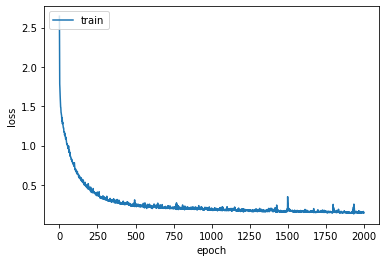

In [45]:
plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [46]:
# 모델 평가하기

scores = model.evaluate(x_train, y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

2/2 [==============================] - 0s 998us/step - loss: 0.1370 - accuracy: 0.9200
accuracy: 92.00%


In [51]:
# 모델 사용하기

pred_count = 50  # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['g8', 'e8','e4','f8']   # 최종 악보
pred_out = model.predict(x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i])
    seq_out.append(idx2code[idx])

print('one step prediction : ', seq_out)

# 곡 전체 예측

seq_in = ['g8', 'e8','e4','f8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in]  #코드 -> 인덱스

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4)) # batch_size, feature
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)
    
print('full song prediction : ', seq_out)  # 7번째 부터 다 틀림 (성능 Bad)

one step prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'e8', 'e8', 'f4 ', 'e8', 'e8', 'e8', 'e8', 'f8', 'f8', 'd8', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']
full song prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8']


### 2. 기본 LSTM 모델
- 128 메모리 셀을 가진 LSTM 레이어 1개와 Dense 레이어로 구성
- 입력은 샘플 50개, 타임스텝 4개, 속성 1개로 구성
- 상태유지(stateful) 모드 비활성화

In [1]:
# 만드려는 모델

# model = Sequential()
# model.add(LSTM(128, input_shape=(4, 1)))
# model.add(Dense(one_hot_vec_size, activation='softmax'))

- input_shape=(4, 1) $<=>$ input_dim=1, input_length=4
- __타임스텝(input_length)__ : 하나의 샘플에 포함된 시퀀스 개수
- __속성(input_dim)__ : 입력되는 음표 1개당 하나의 인덱스 값을 입력하므로 속성이 1개


- MLP 모델과의 차이점 : MLP 모델은 4개의 음표가 4개의 속성으로 입력되고, LSTM에서는 4개의 음표가 4개의 시퀀스 입력으로 들어감 (속성은 1개)

In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [3]:
np.random.seed(5)

In [8]:
# 손실 이력 클래스 정의

class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [9]:
# 데이터셋 생성 함수

def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)

In [10]:
### 1. 데이터 준비하기

# 코드 사전 정의
code2idx = { 'c4' :0, 'd4' :1, 'e4' :2, 'f4' :3, 'g4' :4, 'a4' :5, 'b4' :6,
            'c8' :7, 'd8' :8, 'e8' :9, 'f8' :10, 'g8' :11, 'a8' :12, 'b8' :13}

idx2code = { 0 : 'c4', 1 : 'd4', 2 : 'e4' , 3 :'f4 ' , 4 : 'g4', 5 : 'a4',
            6 : 'b4', 7 : 'c8', 8 : 'd8', 9 : 'e8', 10 : 'f8', 11 : 'g8', 
            12 : 'a8', 13 : 'b8' }

# 시퀀스 데이터 정의
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

In [11]:
### 2. 데이터셋 생성하기

dataset = seq2dataset(seq, window_size=4)

In [35]:
# 입력(X)과 출력(Y) 변수로 분리하기

x_train = dataset[:, 0:4]
y_train = dataset[:, 4]

max_idx_value = 13

In [36]:
# 입력값 정규화 시키기

x_train = x_train / float(max_idx_value)

In [37]:
# 입력을 (샘플 수, 태입스텝, 특성 수)로 형태 변환

x_train = np.reshape(x_train, (50, 4, 1))  # 그냥 차원하나 더해주는거 
                                           # 원래는 (50, 4)

In [38]:
# 라벨값에 대한 one-hot 인코딩 수행

y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]
print('one hot encoding vector size is', one_hot_vec_size)

one hot encoding vector size is 12


In [39]:
### 3. 모델 구성하기

model = Sequential()
model.add(LSTM(128, input_shape=(4, 1)))
model.add(Dense(one_hot_vec_size, activation='softmax'))

In [40]:
### 4. 모델 학습과정 설정하기

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = LossHistory()  # 손실 이력 객체 생성
history.init()

In [49]:
x_train

array([[[0.84615385],
        [0.69230769],
        [0.15384615],
        [0.76923077]],

       [[0.69230769],
        [0.15384615],
        [0.76923077],
        [0.61538462]],

       [[0.15384615],
        [0.76923077],
        [0.61538462],
        [0.07692308]],

       [[0.76923077],
        [0.61538462],
        [0.07692308],
        [0.53846154]],

       [[0.61538462],
        [0.07692308],
        [0.53846154],
        [0.61538462]],

       [[0.07692308],
        [0.53846154],
        [0.61538462],
        [0.69230769]],

       [[0.53846154],
        [0.61538462],
        [0.69230769],
        [0.76923077]],

       [[0.61538462],
        [0.69230769],
        [0.76923077],
        [0.84615385]],

       [[0.69230769],
        [0.76923077],
        [0.84615385],
        [0.84615385]],

       [[0.76923077],
        [0.84615385],
        [0.84615385],
        [0.30769231]],

       [[0.84615385],
        [0.84615385],
        [0.30769231],
        [0.84615385]],

       [[0

In [41]:
### 5. 모델 학습시키기

model.fit(x_train, y_train, epochs=2000, batch_size=14, verbose=2, callbacks=[history])

Epoch 1/2000
4/4 - 0s - loss: 2.4745 - accuracy: 0.1800
Epoch 2/2000
4/4 - 0s - loss: 2.4305 - accuracy: 0.3400
Epoch 3/2000
4/4 - 0s - loss: 2.3836 - accuracy: 0.3400
Epoch 4/2000
4/4 - 0s - loss: 2.3387 - accuracy: 0.3400
Epoch 5/2000
4/4 - 0s - loss: 2.2843 - accuracy: 0.3400
Epoch 6/2000
4/4 - 0s - loss: 2.2194 - accuracy: 0.3400
Epoch 7/2000
4/4 - 0s - loss: 2.1635 - accuracy: 0.3400
Epoch 8/2000
4/4 - 0s - loss: 2.0845 - accuracy: 0.3400
Epoch 9/2000
4/4 - 0s - loss: 2.0252 - accuracy: 0.3400
Epoch 10/2000
4/4 - 0s - loss: 1.9978 - accuracy: 0.3400
Epoch 11/2000
4/4 - 0s - loss: 1.9764 - accuracy: 0.3400
Epoch 12/2000
4/4 - 0s - loss: 1.9541 - accuracy: 0.3400
Epoch 13/2000
4/4 - 0s - loss: 1.9432 - accuracy: 0.3400
Epoch 14/2000
4/4 - 0s - loss: 1.9378 - accuracy: 0.3400
Epoch 15/2000
4/4 - 0s - loss: 1.9300 - accuracy: 0.3400
Epoch 16/2000
4/4 - 0s - loss: 1.9213 - accuracy: 0.3400
Epoch 17/2000
4/4 - 0s - loss: 1.9146 - accuracy: 0.3400
Epoch 18/2000
4/4 - 0s - loss: 1.9106 - 

Epoch 145/2000
4/4 - 0s - loss: 1.6593 - accuracy: 0.3800
Epoch 146/2000
4/4 - 0s - loss: 1.6468 - accuracy: 0.4000
Epoch 147/2000
4/4 - 0s - loss: 1.6400 - accuracy: 0.4000
Epoch 148/2000
4/4 - 0s - loss: 1.6423 - accuracy: 0.4000
Epoch 149/2000
4/4 - 0s - loss: 1.6280 - accuracy: 0.4400
Epoch 150/2000
4/4 - 0s - loss: 1.6461 - accuracy: 0.4000
Epoch 151/2000
4/4 - 0s - loss: 1.6304 - accuracy: 0.4000
Epoch 152/2000
4/4 - 0s - loss: 1.6217 - accuracy: 0.4200
Epoch 153/2000
4/4 - 0s - loss: 1.6319 - accuracy: 0.4000
Epoch 154/2000
4/4 - 0s - loss: 1.6505 - accuracy: 0.4200
Epoch 155/2000
4/4 - 0s - loss: 1.6303 - accuracy: 0.3800
Epoch 156/2000
4/4 - 0s - loss: 1.6211 - accuracy: 0.4200
Epoch 157/2000
4/4 - 0s - loss: 1.6155 - accuracy: 0.4600
Epoch 158/2000
4/4 - 0s - loss: 1.6019 - accuracy: 0.4600
Epoch 159/2000
4/4 - 0s - loss: 1.6077 - accuracy: 0.4000
Epoch 160/2000
4/4 - 0s - loss: 1.6035 - accuracy: 0.4200
Epoch 161/2000
4/4 - 0s - loss: 1.6407 - accuracy: 0.4200
Epoch 162/2000

Epoch 287/2000
4/4 - 0s - loss: 1.3241 - accuracy: 0.5800
Epoch 288/2000
4/4 - 0s - loss: 1.3111 - accuracy: 0.5800
Epoch 289/2000
4/4 - 0s - loss: 1.3082 - accuracy: 0.5800
Epoch 290/2000
4/4 - 0s - loss: 1.3112 - accuracy: 0.5600
Epoch 291/2000
4/4 - 0s - loss: 1.3051 - accuracy: 0.5400
Epoch 292/2000
4/4 - 0s - loss: 1.3111 - accuracy: 0.5600
Epoch 293/2000
4/4 - 0s - loss: 1.3298 - accuracy: 0.5600
Epoch 294/2000
4/4 - 0s - loss: 1.3018 - accuracy: 0.5200
Epoch 295/2000
4/4 - 0s - loss: 1.2984 - accuracy: 0.5800
Epoch 296/2000
4/4 - 0s - loss: 1.2997 - accuracy: 0.5800
Epoch 297/2000
4/4 - 0s - loss: 1.3099 - accuracy: 0.6000
Epoch 298/2000
4/4 - 0s - loss: 1.3026 - accuracy: 0.5800
Epoch 299/2000
4/4 - 0s - loss: 1.2987 - accuracy: 0.5000
Epoch 300/2000
4/4 - 0s - loss: 1.3062 - accuracy: 0.5200
Epoch 301/2000
4/4 - 0s - loss: 1.2902 - accuracy: 0.5800
Epoch 302/2000
4/4 - 0s - loss: 1.2873 - accuracy: 0.5800
Epoch 303/2000
4/4 - 0s - loss: 1.2703 - accuracy: 0.5600
Epoch 304/2000

Epoch 429/2000
4/4 - 0s - loss: 1.0528 - accuracy: 0.6400
Epoch 430/2000
4/4 - 0s - loss: 1.0239 - accuracy: 0.6200
Epoch 431/2000
4/4 - 0s - loss: 1.0230 - accuracy: 0.6200
Epoch 432/2000
4/4 - 0s - loss: 1.0216 - accuracy: 0.6200
Epoch 433/2000
4/4 - 0s - loss: 1.0350 - accuracy: 0.5800
Epoch 434/2000
4/4 - 0s - loss: 1.0289 - accuracy: 0.6000
Epoch 435/2000
4/4 - 0s - loss: 1.0198 - accuracy: 0.6000
Epoch 436/2000
4/4 - 0s - loss: 1.0456 - accuracy: 0.6200
Epoch 437/2000
4/4 - 0s - loss: 1.0216 - accuracy: 0.6200
Epoch 438/2000
4/4 - 0s - loss: 1.0167 - accuracy: 0.6400
Epoch 439/2000
4/4 - 0s - loss: 0.9986 - accuracy: 0.6200
Epoch 440/2000
4/4 - 0s - loss: 0.9963 - accuracy: 0.6200
Epoch 441/2000
4/4 - 0s - loss: 1.0164 - accuracy: 0.6000
Epoch 442/2000
4/4 - 0s - loss: 1.0054 - accuracy: 0.5800
Epoch 443/2000
4/4 - 0s - loss: 0.9977 - accuracy: 0.6000
Epoch 444/2000
4/4 - 0s - loss: 0.9956 - accuracy: 0.6200
Epoch 445/2000
4/4 - 0s - loss: 1.0126 - accuracy: 0.6000
Epoch 446/2000

Epoch 571/2000
4/4 - 0s - loss: 0.7539 - accuracy: 0.7200
Epoch 572/2000
4/4 - 0s - loss: 0.7850 - accuracy: 0.6600
Epoch 573/2000
4/4 - 0s - loss: 0.7542 - accuracy: 0.7400
Epoch 574/2000
4/4 - 0s - loss: 0.7628 - accuracy: 0.7200
Epoch 575/2000
4/4 - 0s - loss: 0.7751 - accuracy: 0.7000
Epoch 576/2000
4/4 - 0s - loss: 0.7314 - accuracy: 0.7800
Epoch 577/2000
4/4 - 0s - loss: 0.7702 - accuracy: 0.6800
Epoch 578/2000
4/4 - 0s - loss: 0.7433 - accuracy: 0.7400
Epoch 579/2000
4/4 - 0s - loss: 0.7508 - accuracy: 0.7000
Epoch 580/2000
4/4 - 0s - loss: 0.7341 - accuracy: 0.7400
Epoch 581/2000
4/4 - 0s - loss: 0.7433 - accuracy: 0.7400
Epoch 582/2000
4/4 - 0s - loss: 0.7332 - accuracy: 0.7600
Epoch 583/2000
4/4 - 0s - loss: 0.7474 - accuracy: 0.7000
Epoch 584/2000
4/4 - 0s - loss: 0.7372 - accuracy: 0.7600
Epoch 585/2000
4/4 - 0s - loss: 0.7416 - accuracy: 0.7200
Epoch 586/2000
4/4 - 0s - loss: 0.7407 - accuracy: 0.7200
Epoch 587/2000
4/4 - 0s - loss: 0.7428 - accuracy: 0.7200
Epoch 588/2000

Epoch 713/2000
4/4 - 0s - loss: 0.6153 - accuracy: 0.8000
Epoch 714/2000
4/4 - 0s - loss: 0.6123 - accuracy: 0.7800
Epoch 715/2000
4/4 - 0s - loss: 0.6284 - accuracy: 0.8000
Epoch 716/2000
4/4 - 0s - loss: 0.6188 - accuracy: 0.7400
Epoch 717/2000
4/4 - 0s - loss: 0.6174 - accuracy: 0.8200
Epoch 718/2000
4/4 - 0s - loss: 0.6016 - accuracy: 0.7400
Epoch 719/2000
4/4 - 0s - loss: 0.5872 - accuracy: 0.8000
Epoch 720/2000
4/4 - 0s - loss: 0.5705 - accuracy: 0.8200
Epoch 721/2000
4/4 - 0s - loss: 0.6079 - accuracy: 0.8200
Epoch 722/2000
4/4 - 0s - loss: 0.6041 - accuracy: 0.7800
Epoch 723/2000
4/4 - 0s - loss: 0.5574 - accuracy: 0.8400
Epoch 724/2000
4/4 - 0s - loss: 0.5792 - accuracy: 0.8600
Epoch 725/2000
4/4 - 0s - loss: 0.5703 - accuracy: 0.7800
Epoch 726/2000
4/4 - 0s - loss: 0.5690 - accuracy: 0.8000
Epoch 727/2000
4/4 - 0s - loss: 0.5747 - accuracy: 0.8200
Epoch 728/2000
4/4 - 0s - loss: 0.5765 - accuracy: 0.7600
Epoch 729/2000
4/4 - 0s - loss: 0.5730 - accuracy: 0.8200
Epoch 730/2000

Epoch 855/2000
4/4 - 0s - loss: 0.4766 - accuracy: 0.8400
Epoch 856/2000
4/4 - 0s - loss: 0.5336 - accuracy: 0.8200
Epoch 857/2000
4/4 - 0s - loss: 0.5261 - accuracy: 0.8000
Epoch 858/2000
4/4 - 0s - loss: 0.5089 - accuracy: 0.8200
Epoch 859/2000
4/4 - 0s - loss: 0.5339 - accuracy: 0.7800
Epoch 860/2000
4/4 - 0s - loss: 0.5017 - accuracy: 0.8400
Epoch 861/2000
4/4 - 0s - loss: 0.4923 - accuracy: 0.8800
Epoch 862/2000
4/4 - 0s - loss: 0.5076 - accuracy: 0.8600
Epoch 863/2000
4/4 - 0s - loss: 0.4904 - accuracy: 0.8200
Epoch 864/2000
4/4 - 0s - loss: 0.4991 - accuracy: 0.8600
Epoch 865/2000
4/4 - 0s - loss: 0.4905 - accuracy: 0.8400
Epoch 866/2000
4/4 - 0s - loss: 0.4982 - accuracy: 0.7800
Epoch 867/2000
4/4 - 0s - loss: 0.4730 - accuracy: 0.8800
Epoch 868/2000
4/4 - 0s - loss: 0.4921 - accuracy: 0.8600
Epoch 869/2000
4/4 - 0s - loss: 0.4865 - accuracy: 0.8200
Epoch 870/2000
4/4 - 0s - loss: 0.4906 - accuracy: 0.8400
Epoch 871/2000
4/4 - 0s - loss: 0.5104 - accuracy: 0.8400
Epoch 872/2000

4/4 - 0s - loss: 0.4317 - accuracy: 0.8400
Epoch 997/2000
4/4 - 0s - loss: 0.4587 - accuracy: 0.8600
Epoch 998/2000
4/4 - 0s - loss: 0.4374 - accuracy: 0.8600
Epoch 999/2000
4/4 - 0s - loss: 0.4460 - accuracy: 0.8200
Epoch 1000/2000
4/4 - 0s - loss: 0.4292 - accuracy: 0.8800
Epoch 1001/2000
4/4 - 0s - loss: 0.4351 - accuracy: 0.8600
Epoch 1002/2000
4/4 - 0s - loss: 0.4237 - accuracy: 0.8600
Epoch 1003/2000
4/4 - 0s - loss: 0.4257 - accuracy: 0.8600
Epoch 1004/2000
4/4 - 0s - loss: 0.4377 - accuracy: 0.8400
Epoch 1005/2000
4/4 - 0s - loss: 0.4538 - accuracy: 0.8400
Epoch 1006/2000
4/4 - 0s - loss: 0.4609 - accuracy: 0.8000
Epoch 1007/2000
4/4 - 0s - loss: 0.4389 - accuracy: 0.8400
Epoch 1008/2000
4/4 - 0s - loss: 0.4311 - accuracy: 0.8600
Epoch 1009/2000
4/4 - 0s - loss: 0.4356 - accuracy: 0.8400
Epoch 1010/2000
4/4 - 0s - loss: 0.4531 - accuracy: 0.8600
Epoch 1011/2000
4/4 - 0s - loss: 0.4182 - accuracy: 0.8400
Epoch 1012/2000
4/4 - 0s - loss: 0.4788 - accuracy: 0.8200
Epoch 1013/2000


Epoch 1136/2000
4/4 - 0s - loss: 0.3841 - accuracy: 0.8600
Epoch 1137/2000
4/4 - 0s - loss: 0.4156 - accuracy: 0.8600
Epoch 1138/2000
4/4 - 0s - loss: 0.4093 - accuracy: 0.8400
Epoch 1139/2000
4/4 - 0s - loss: 0.3804 - accuracy: 0.8800
Epoch 1140/2000
4/4 - 0s - loss: 0.4002 - accuracy: 0.8600
Epoch 1141/2000
4/4 - 0s - loss: 0.3957 - accuracy: 0.8600
Epoch 1142/2000
4/4 - 0s - loss: 0.4028 - accuracy: 0.8800
Epoch 1143/2000
4/4 - 0s - loss: 0.3957 - accuracy: 0.8400
Epoch 1144/2000
4/4 - 0s - loss: 0.4077 - accuracy: 0.8600
Epoch 1145/2000
4/4 - 0s - loss: 0.3872 - accuracy: 0.8600
Epoch 1146/2000
4/4 - 0s - loss: 0.4135 - accuracy: 0.8600
Epoch 1147/2000
4/4 - 0s - loss: 0.4066 - accuracy: 0.8600
Epoch 1148/2000
4/4 - 0s - loss: 0.3837 - accuracy: 0.8600
Epoch 1149/2000
4/4 - 0s - loss: 0.4159 - accuracy: 0.8000
Epoch 1150/2000
4/4 - 0s - loss: 0.4077 - accuracy: 0.8600
Epoch 1151/2000
4/4 - 0s - loss: 0.3846 - accuracy: 0.9000
Epoch 1152/2000
4/4 - 0s - loss: 0.3869 - accuracy: 0.86

Epoch 1275/2000
4/4 - 0s - loss: 0.3742 - accuracy: 0.9000
Epoch 1276/2000
4/4 - 0s - loss: 0.3723 - accuracy: 0.8600
Epoch 1277/2000
4/4 - 0s - loss: 0.3653 - accuracy: 0.8600
Epoch 1278/2000
4/4 - 0s - loss: 0.3794 - accuracy: 0.8600
Epoch 1279/2000
4/4 - 0s - loss: 0.3860 - accuracy: 0.8400
Epoch 1280/2000
4/4 - 0s - loss: 0.3537 - accuracy: 0.8400
Epoch 1281/2000
4/4 - 0s - loss: 0.3685 - accuracy: 0.8800
Epoch 1282/2000
4/4 - 0s - loss: 0.3689 - accuracy: 0.8800
Epoch 1283/2000
4/4 - 0s - loss: 0.3904 - accuracy: 0.8400
Epoch 1284/2000
4/4 - 0s - loss: 0.3680 - accuracy: 0.8800
Epoch 1285/2000
4/4 - 0s - loss: 0.3913 - accuracy: 0.8200
Epoch 1286/2000
4/4 - 0s - loss: 0.3799 - accuracy: 0.8600
Epoch 1287/2000
4/4 - 0s - loss: 0.3533 - accuracy: 0.9000
Epoch 1288/2000
4/4 - 0s - loss: 0.3820 - accuracy: 0.8400
Epoch 1289/2000
4/4 - 0s - loss: 0.3570 - accuracy: 0.8400
Epoch 1290/2000
4/4 - 0s - loss: 0.3594 - accuracy: 0.8400
Epoch 1291/2000
4/4 - 0s - loss: 0.3782 - accuracy: 0.88

Epoch 1414/2000
4/4 - 0s - loss: 0.3545 - accuracy: 0.8600
Epoch 1415/2000
4/4 - 0s - loss: 0.3569 - accuracy: 0.8800
Epoch 1416/2000
4/4 - 0s - loss: 0.3386 - accuracy: 0.8800
Epoch 1417/2000
4/4 - 0s - loss: 0.3462 - accuracy: 0.8600
Epoch 1418/2000
4/4 - 0s - loss: 0.3341 - accuracy: 0.8800
Epoch 1419/2000
4/4 - 0s - loss: 0.3454 - accuracy: 0.8600
Epoch 1420/2000
4/4 - 0s - loss: 0.3320 - accuracy: 0.8600
Epoch 1421/2000
4/4 - 0s - loss: 0.3392 - accuracy: 0.8600
Epoch 1422/2000
4/4 - 0s - loss: 0.3280 - accuracy: 0.8600
Epoch 1423/2000
4/4 - 0s - loss: 0.3480 - accuracy: 0.8600
Epoch 1424/2000
4/4 - 0s - loss: 0.3325 - accuracy: 0.8400
Epoch 1425/2000
4/4 - 0s - loss: 0.3412 - accuracy: 0.8600
Epoch 1426/2000
4/4 - 0s - loss: 0.3417 - accuracy: 0.8600
Epoch 1427/2000
4/4 - 0s - loss: 0.3421 - accuracy: 0.8800
Epoch 1428/2000
4/4 - 0s - loss: 0.3324 - accuracy: 0.8600
Epoch 1429/2000
4/4 - 0s - loss: 0.3477 - accuracy: 0.9000
Epoch 1430/2000
4/4 - 0s - loss: 0.3313 - accuracy: 0.88

Epoch 1553/2000
4/4 - 0s - loss: 0.3197 - accuracy: 0.8600
Epoch 1554/2000
4/4 - 0s - loss: 0.3325 - accuracy: 0.8600
Epoch 1555/2000
4/4 - 0s - loss: 0.3359 - accuracy: 0.8600
Epoch 1556/2000
4/4 - 0s - loss: 0.3407 - accuracy: 0.8400
Epoch 1557/2000
4/4 - 0s - loss: 0.3264 - accuracy: 0.8400
Epoch 1558/2000
4/4 - 0s - loss: 0.3164 - accuracy: 0.8400
Epoch 1559/2000
4/4 - 0s - loss: 0.3186 - accuracy: 0.8800
Epoch 1560/2000
4/4 - 0s - loss: 0.3236 - accuracy: 0.8600
Epoch 1561/2000
4/4 - 0s - loss: 0.3207 - accuracy: 0.8600
Epoch 1562/2000
4/4 - 0s - loss: 0.3298 - accuracy: 0.8400
Epoch 1563/2000
4/4 - 0s - loss: 0.3175 - accuracy: 0.8600
Epoch 1564/2000
4/4 - 0s - loss: 0.3252 - accuracy: 0.8800
Epoch 1565/2000
4/4 - 0s - loss: 0.3174 - accuracy: 0.8800
Epoch 1566/2000
4/4 - 0s - loss: 0.3205 - accuracy: 0.8800
Epoch 1567/2000
4/4 - 0s - loss: 0.3176 - accuracy: 0.8600
Epoch 1568/2000
4/4 - 0s - loss: 0.3114 - accuracy: 0.8600
Epoch 1569/2000
4/4 - 0s - loss: 0.3204 - accuracy: 0.84

Epoch 1692/2000
4/4 - 0s - loss: 0.3190 - accuracy: 0.8600
Epoch 1693/2000
4/4 - 0s - loss: 0.3211 - accuracy: 0.8800
Epoch 1694/2000
4/4 - 0s - loss: 0.3011 - accuracy: 0.8800
Epoch 1695/2000
4/4 - 0s - loss: 0.3214 - accuracy: 0.8600
Epoch 1696/2000
4/4 - 0s - loss: 0.2996 - accuracy: 0.9000
Epoch 1697/2000
4/4 - 0s - loss: 0.3166 - accuracy: 0.8800
Epoch 1698/2000
4/4 - 0s - loss: 0.3069 - accuracy: 0.9000
Epoch 1699/2000
4/4 - 0s - loss: 0.3125 - accuracy: 0.9000
Epoch 1700/2000
4/4 - 0s - loss: 0.3145 - accuracy: 0.8600
Epoch 1701/2000
4/4 - 0s - loss: 0.2943 - accuracy: 0.9000
Epoch 1702/2000
4/4 - 0s - loss: 0.3137 - accuracy: 0.8800
Epoch 1703/2000
4/4 - 0s - loss: 0.3076 - accuracy: 0.9000
Epoch 1704/2000
4/4 - 0s - loss: 0.2961 - accuracy: 0.9000
Epoch 1705/2000
4/4 - 0s - loss: 0.3261 - accuracy: 0.8600
Epoch 1706/2000
4/4 - 0s - loss: 0.3189 - accuracy: 0.9000
Epoch 1707/2000
4/4 - 0s - loss: 0.3416 - accuracy: 0.8600
Epoch 1708/2000
4/4 - 0s - loss: 0.3531 - accuracy: 0.86

Epoch 1831/2000
4/4 - 0s - loss: 0.2943 - accuracy: 0.8600
Epoch 1832/2000
4/4 - 0s - loss: 0.2855 - accuracy: 0.8800
Epoch 1833/2000
4/4 - 0s - loss: 0.2892 - accuracy: 0.8800
Epoch 1834/2000
4/4 - 0s - loss: 0.3031 - accuracy: 0.8600
Epoch 1835/2000
4/4 - 0s - loss: 0.2920 - accuracy: 0.8600
Epoch 1836/2000
4/4 - 0s - loss: 0.3012 - accuracy: 0.8800
Epoch 1837/2000
4/4 - 0s - loss: 0.2880 - accuracy: 0.8800
Epoch 1838/2000
4/4 - 0s - loss: 0.2905 - accuracy: 0.9000
Epoch 1839/2000
4/4 - 0s - loss: 0.2964 - accuracy: 0.8800
Epoch 1840/2000
4/4 - 0s - loss: 0.3031 - accuracy: 0.8400
Epoch 1841/2000
4/4 - 0s - loss: 0.2898 - accuracy: 0.8800
Epoch 1842/2000
4/4 - 0s - loss: 0.2887 - accuracy: 0.8800
Epoch 1843/2000
4/4 - 0s - loss: 0.2906 - accuracy: 0.8800
Epoch 1844/2000
4/4 - 0s - loss: 0.2909 - accuracy: 0.8600
Epoch 1845/2000
4/4 - 0s - loss: 0.2905 - accuracy: 0.8600
Epoch 1846/2000
4/4 - 0s - loss: 0.2881 - accuracy: 0.8800
Epoch 1847/2000
4/4 - 0s - loss: 0.2908 - accuracy: 0.88

Epoch 1970/2000
4/4 - 0s - loss: 0.3107 - accuracy: 0.8800
Epoch 1971/2000
4/4 - 0s - loss: 0.2882 - accuracy: 0.8600
Epoch 1972/2000
4/4 - 0s - loss: 0.3089 - accuracy: 0.8600
Epoch 1973/2000
4/4 - 0s - loss: 0.2931 - accuracy: 0.8800
Epoch 1974/2000
4/4 - 0s - loss: 0.2832 - accuracy: 0.9000
Epoch 1975/2000
4/4 - 0s - loss: 0.2884 - accuracy: 0.8800
Epoch 1976/2000
4/4 - 0s - loss: 0.2949 - accuracy: 0.8800
Epoch 1977/2000
4/4 - 0s - loss: 0.2888 - accuracy: 0.8400
Epoch 1978/2000
4/4 - 0s - loss: 0.2857 - accuracy: 0.8600
Epoch 1979/2000
4/4 - 0s - loss: 0.2895 - accuracy: 0.8600
Epoch 1980/2000
4/4 - 0s - loss: 0.2821 - accuracy: 0.8600
Epoch 1981/2000
4/4 - 0s - loss: 0.3021 - accuracy: 0.8600
Epoch 1982/2000
4/4 - 0s - loss: 0.2734 - accuracy: 0.9000
Epoch 1983/2000
4/4 - 0s - loss: 0.2938 - accuracy: 0.8600
Epoch 1984/2000
4/4 - 0s - loss: 0.2919 - accuracy: 0.8800
Epoch 1985/2000
4/4 - 0s - loss: 0.2899 - accuracy: 0.8600
Epoch 1986/2000
4/4 - 0s - loss: 0.2961 - accuracy: 0.86

In [43]:
history.losses

[2.4745116233825684,
 2.4304986000061035,
 2.383610486984253,
 2.3386611938476562,
 2.284309148788452,
 2.2194347381591797,
 2.1635146141052246,
 2.084451675415039,
 2.025163173675537,
 1.9978394508361816,
 1.9764279127120972,
 1.954117774963379,
 1.9431568384170532,
 1.9377871751785278,
 1.9299839735031128,
 1.9212918281555176,
 1.914627194404602,
 1.9106264114379883,
 1.9055886268615723,
 1.900715947151184,
 1.901940107345581,
 1.899766445159912,
 1.8977749347686768,
 1.8943437337875366,
 1.8929997682571411,
 1.8918938636779785,
 1.8947455883026123,
 1.8928204774856567,
 1.8897156715393066,
 1.8882336616516113,
 1.8864418268203735,
 1.8864434957504272,
 1.8938807249069214,
 1.8842257261276245,
 1.8821254968643188,
 1.8830970525741577,
 1.8822729587554932,
 1.882207989692688,
 1.881481647491455,
 1.8796334266662598,
 1.877876877784729,
 1.876114845275879,
 1.8743863105773926,
 1.8776758909225464,
 1.8754173517227173,
 1.873520016670227,
 1.8756426572799683,
 1.8749929666519165,
 1.868

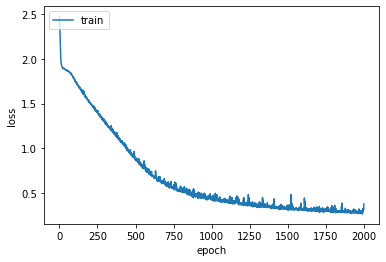

In [44]:
### 6. 학습과정 살펴보기

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [45]:
### 7. 모델 평가하기

scores = model.evaluate(x_train, y_train)
print('%s: %.2f%%' %(model.metrics_names[1], scores[1]*100))

2/2 [==============================] - 0s 2ms/step - loss: 0.2759 - accuracy: 0.8800
accuracy: 88.00%


In [51]:
### 8. 모델 사용하기

pred_count = 50  # 최대 예측 개수 정의

# 한 스텝 예측
seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i])
    seq_out.append(idx2code[idx])

print('one step prediction : ', seq_out)

# 곡 전체 예측
seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4, 1))  # 샘플수, 타임스텝수, 속성수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)
    
print('full song prediction : ', seq_out)

one step prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'f8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'e8', 'e8', 'f4 ', 'e8', 'e8', 'e8', 'e8', 'f8', 'f8', 'f8', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']
full song prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4 ', 'e8', 'e8', 'e8', 'e8', 'f8', 'f8', 'd4', 'c8', 'e8', 'd8', 'g8', 'e8', 'd4', 'e8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4 ', 'e8', 'e8', 'e8', 'e8', 'f8', 'f8']
